In [1]:
import os, urllib.request, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(f"PyTorch version : {torch.__version__}")
device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps")  if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"Using device    : {device}")

PyTorch version : 2.9.0+cpu
Using device    : cpu


In [2]:
# ── 하이퍼파라미터 (필요 시 수정) ──────────────────────────────────────────────
CFG = dict(
    data_dir   = "./data",
    batch_size = 64,
    epochs     = 50,
    lr         = 1e-3,
    dropout    = 0.3,
    seed       = 42,
)
torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])

# ── 데이터 다운로드 ─────────────────────────────────────────────────────────────
def download_ecg5000(save_dir: str):
    os.makedirs(save_dir, exist_ok=True)
    train_path = os.path.join(save_dir, "ECG5000_TRAIN.txt")
    test_path  = os.path.join(save_dir, "ECG5000_TEST.txt")

    if not (os.path.exists(train_path) and os.path.exists(test_path)):
        print("Downloading ECG5000 ...")
        url      = "https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip"
        zip_path = os.path.join(save_dir, "ECG5000.zip")
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(save_dir)
        for root, _, files in os.walk(save_dir):
            for f in files:
                src = os.path.join(root, f)
                if "_TRAIN" in f and f.endswith(".txt"):
                    os.replace(src, train_path)
                elif "_TEST" in f and f.endswith(".txt"):
                    os.replace(src, test_path)
        os.remove(zip_path)
        print("Done!")
    else:
        print("Using cached data.")

    def _load(path):
        arr = pd.read_csv(path, header=None, sep=r"\s+").values.astype(np.float32)
        return arr[:, 1:], arr[:, 0].astype(int)   # X, y

    X_tr, y_tr = _load(train_path)
    X_te, y_te = _load(test_path)

    le = LabelEncoder().fit(np.concatenate([y_tr, y_te]))
    return X_tr, le.transform(y_tr), X_te, le.transform(y_te)

X_train, y_train, X_test, y_test = download_ecg5000(CFG["data_dir"])

NUM_CLASSES = len(np.unique(y_train))
SEQ_LEN     = X_train.shape[1]

print(f"X_train : {X_train.shape}  |  y_train : {y_train.shape}")
print(f"X_test  : {X_test.shape}   |  y_test  : {y_test.shape}")
print(f"Classes : {NUM_CLASSES}  |  Seq len : {SEQ_LEN}")
print(f"Label dist (train): { {c: int((y_train==c).sum()) for c in range(NUM_CLASSES)} }")

Done!
X_train : (500, 140)  |  y_train : (500,)
X_test  : (4500, 140)   |  y_test  : (4500,)
Classes : 5  |  Seq len : 140
Label dist (train): {0: 292, 1: 177, 2: 10, 3: 19, 4: 2}


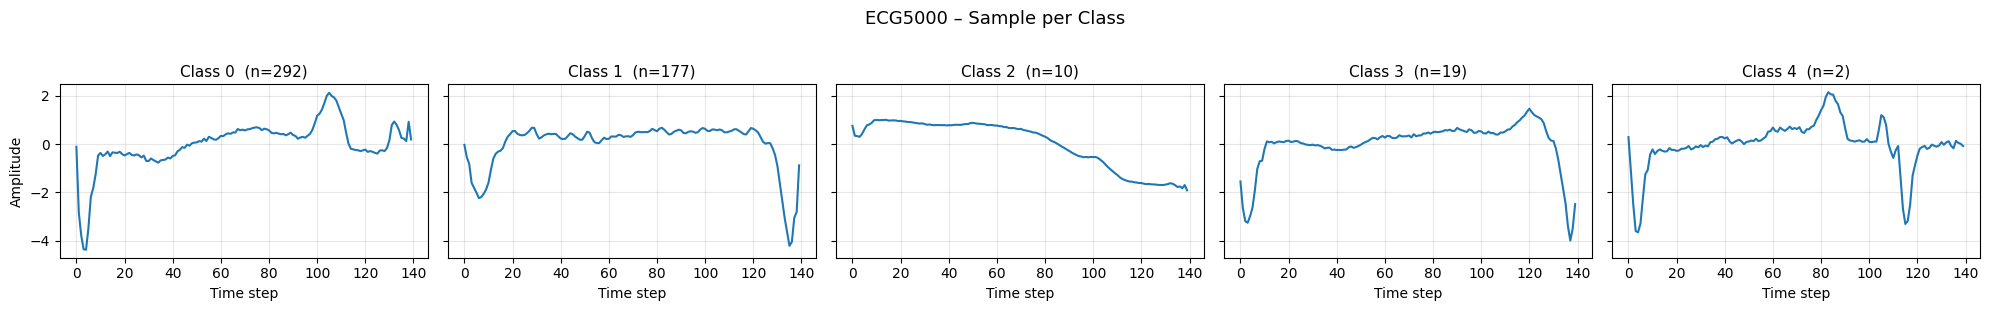

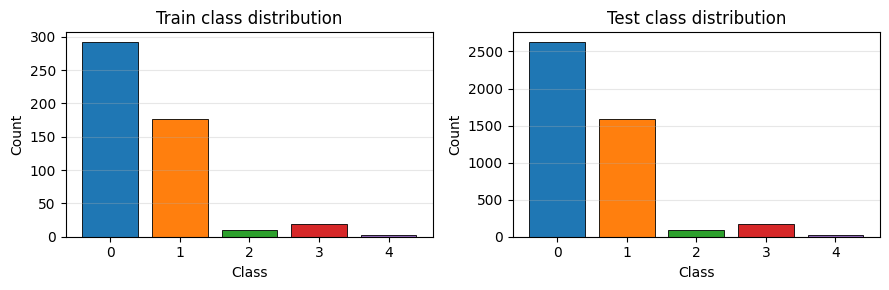

In [3]:
# ── 클래스별 샘플 시각화 ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(4 * NUM_CLASSES, 3), sharey=True)
for cls, ax in enumerate(axes):
    idx = np.where(y_train == cls)[0][0]
    ax.plot(X_train[idx], linewidth=1.5)
    ax.set_title(f"Class {cls}  (n={int((y_train==cls).sum())})", fontsize=11)
    ax.set_xlabel("Time step")
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel("Amplitude")
fig.suptitle("ECG5000 – Sample per Class", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# ── 클래스 분포 ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for ax, (split, y) in zip(axes, [("Train", y_train), ("Test", y_test)]):
    counts = [int((y == c).sum()) for c in range(NUM_CLASSES)]
    ax.bar(range(NUM_CLASSES), counts, color=plt.cm.tab10.colors[:NUM_CLASSES], edgecolor="k", linewidth=0.6)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_title(f"{split} class distribution")
    ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
class TimeSeriesDataset(Dataset):
    """(N, L) numpy → (N, 1, L) tensor (CNN channel-first)"""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N,1,L)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):  return len(self.y)
    def __getitem__(self, i):  return self.X[i], self.y[i]


train_ds = TimeSeriesDataset(X_train, y_train)
test_ds  = TimeSeriesDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, num_workers=0, pin_memory=True)

# 배치 shape 확인
xb, yb = next(iter(train_loader))
print(f"Batch X : {xb.shape}   (batch, channel, seq_len)")
print(f"Batch y : {yb.shape}   values={yb[:8].tolist()}")

Batch X : torch.Size([64, 1, 140])   (batch, channel, seq_len)
Batch y : torch.Size([64])   values=[0, 1, 0, 1, 0, 0, 0, 1]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [5]:
class VGG1dBlockl1(nn.Module):
  """Conv1d → BatchNorm → ReLU → Dropout → (MaxPool)"""
  def __init__(self, in_ch, out_ch, pool=True, dropout=0.3):
    super().__init__()
    layers = [
        nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(),
        nn.Dropout(dropout),
    ]
    if pool:
      layers.append(nn.MaxPool1d(2))
    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)


class VGG1dBlockl2(nn.Module):
    """Conv1d → BatchNorm → ReLU → Conv1d → BatchNorm → ReLU → Dropout → (MaxPool)"""
    def __init__(self, in_ch, out_ch, pool=True, dropout=0.3):
        super().__init__()
        layers = [
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout),
        ]
        if pool:
            layers.append(nn.MaxPool1d(2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class VGG(nn.Module):
    """
    Based on VGG11
    Input  : (B, 1, L)
    Block1 : Conv(64, k=3) → BN → ReLU → Dropout → MaxPool
    Block2 : Conv(128, k=3) → BN → ReLU → Dropout → MaxPool
    Block3 : Conv(256, k=3) → BN → ReLU → Conv(256, k=3) → BN → ReLU → Dropout → MaxPool
    Block4 : Conv(512, k=3) → BN → ReLU → Conv(512, k=3) → BN → ReLU → Dropout → MaxPool
    Block5 : Conv(512, k=3) → BN → ReLU → Conv(512, k=3) → BN → ReLU → Dropout → MaxPool
    GAP    : AdaptiveAvgPool → (B, 512, 1)
    Head   : FC(512) → ReLU → FC(512) → ReLU → Dropout → FC(num_classes)
    """
    def __init__(self, num_classes: int, dropout: float = 0.3):
        super().__init__()
        self.features = nn.Sequential(
            VGG1dBlockl1(1,   64,  dropout=dropout),
            VGG1dBlockl1(64,  128, dropout=dropout),
            VGG1dBlockl2(128, 256, dropout=dropout),
            VGG1dBlockl2(256, 512, dropout=dropout),
            VGG1dBlockl2(512, 512, dropout=dropout),
        )
        self.gap = nn.AdaptiveAvgPool1d(1)           # Global Average Pooling
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)   # (B, 512, L')
        x = self.gap(x)        # (B, 512, 1)
        return self.classifier(x)


# ── 인스턴스화 ─────────────────────────────────────────────────────────────────
model     = VGG(num_classes=NUM_CLASSES, dropout=CFG["dropout"]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG["lr"])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTrainable params: {total_params:,}")

VGG(
  (features): Sequential(
    (0): VGG1dBlockl1(
      (block): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGG1dBlockl1(
      (block): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): VGG1dBlockl2(
      (block): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
def run_epoch(model, loader, criterion, optimizer=None):
    """
    optimizer=None  → eval 모드 (기울기 계산 X)
    optimizer 전달  → train 모드
    """
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, correct, total = 0.0, 0, 0
    ctx = torch.enable_grad() if training else torch.no_grad()

    with ctx:
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss   = criterion(logits, y_batch)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * len(y_batch)
            correct    += (logits.argmax(1) == y_batch).sum().item()
            total      += len(y_batch)

    return total_loss / total, correct / total


# ── 학습 루프 ──────────────────────────────────────────────────────────────────
history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}
best_val_acc, best_epoch = 0.0, 0

for epoch in range(1, CFG["epochs"] + 1):
    tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer)
    va_loss, va_acc = run_epoch(model, test_loader,  criterion)
    scheduler.step()

    history["tr_loss"].append(tr_loss); history["va_loss"].append(va_loss)
    history["tr_acc"].append(tr_acc);   history["va_acc"].append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_epoch   = epoch
        torch.save(model.state_dict(), "best_model.pth")

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{CFG['epochs']} | "
              f"Train  loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"Val  loss={va_loss:.4f} acc={va_acc:.4f}")

print(f"\n✓ Best Val Accuracy : {best_val_acc:.4f}  (epoch {best_epoch})")

# ── 학습 곡선 ──────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, key, title in zip(axes, ["loss", "acc"], ["Loss", "Accuracy"]):
    ax.plot(history[f"tr_{key}"], label="Train")
    ax.plot(history[f"va_{key}"], label="Val",   linestyle="--")
    ax.axvline(best_epoch - 1, color="r", linewidth=0.8, linestyle=":", label=f"Best (e{best_epoch})")
    ax.set_title(title); ax.set_xlabel("Epoch"); ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch   1/50 | Train  loss=0.7014 acc=0.7480 | Val  loss=1.3903 acc=0.3533


In [ ]:
# ── Best 모델 로드 & 추론 ──────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits  = model(X_batch)
        probs   = torch.softmax(logits, dim=1)
        preds   = logits.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

test_acc = (all_preds == all_labels).mean()
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Best Val Acc   : {best_val_acc:.4f}\n")
print("─" * 50)
print(classification_report(all_labels, all_preds,
                             target_names=[f"Class {c}" for c in range(NUM_CLASSES)]))

In [ ]:
# ── 혼동 행렬 ──────────────────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)   # row-normalize

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"C{c}" for c in range(NUM_CLASSES)],
            yticklabels=[f"C{c}" for c in range(NUM_CLASSES)],
            ax=axes[0], linewidths=0.5)
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=[f"C{c}" for c in range(NUM_CLASSES)],
            yticklabels=[f"C{c}" for c in range(NUM_CLASSES)],
            ax=axes[1], linewidths=0.5, vmin=0, vmax=1)
axes[1].set_title("Confusion Matrix (normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

# ── 예측 신뢰도 분포 ────────────────────────────────────────────────────────────
max_probs = all_probs.max(axis=1)
correct_mask = all_preds == all_labels

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(max_probs[correct_mask],  bins=30, alpha=0.6, color="steelblue", label="Correct")
ax.hist(max_probs[~correct_mask], bins=30, alpha=0.6, color="tomato",    label="Wrong")
ax.set_xlabel("Max Softmax Probability (confidence)")
ax.set_ylabel("Count")
ax.set_title("Prediction Confidence Distribution")
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── 정성적 예측 샘플 시각화 (각 클래스 1개) ────────────────────────────────────
fig, axes = plt.subplots(2, NUM_CLASSES, figsize=(4 * NUM_CLASSES, 6))
for cls in range(NUM_CLASSES):
    idxs = np.where(all_labels == cls)[0]
    idx  = idxs[0]

    pred, conf = all_preds[idx], all_probs[idx].max()
    correct = pred == cls
    color = "steelblue" if correct else "tomato"
    icon  = "✓" if correct else "✗"

    # 시계열
    axes[0, cls].plot(X_test[idx], color=color, linewidth=1.5)
    axes[0, cls].set_title(f"True: C{cls}  Pred: C{pred} {icon}\nConf: {conf:.2f}",
                           fontsize=10, color=color)
    axes[0, cls].grid(True, alpha=0.3)
    axes[0, cls].set_xlabel("Time step")

    # Softmax 확률 bar
    axes[1, cls].bar(range(NUM_CLASSES), all_probs[idx],
                     color=[color if i == pred else "lightgray" for i in range(NUM_CLASSES)],
                     edgecolor="k", linewidth=0.5)
    axes[1, cls].set_xticks(range(NUM_CLASSES))
    axes[1, cls].set_xticklabels([f"C{c}" for c in range(NUM_CLASSES)])
    axes[1, cls].set_ylim(0, 1)
    axes[1, cls].set_ylabel("Probability")
    axes[1, cls].set_title("Softmax Output")
    axes[1, cls].grid(axis="y", alpha=0.3)

plt.suptitle("Per-Class Prediction Sample", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
def print_model_summary(model, input_size, device='cpu'):
    """
    torchinfo를 사용한 모델 요약 (설치 필요: pip install torchinfo)

    Args:
        model: PyTorch 모델
        input_size: tuple, (batch_size, channels, seq_len)
        device: 'cpu' or 'cuda'
    """
    try:
        from torchinfo import summary
        print("=" * 80)
        print("모델 아키텍처 상세 정보 (torchinfo)")
        print("=" * 80)
        summary(
            model,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            row_settings=["var_names"],
            verbose=1,
            device=device
        )
    except ImportError:
        print("torchinfo가 설치되지 않았습니다.")
        print("설치: pip install torchinfo")
        print("\n기본 모델 정보:")
        print(model)


def print_layer_parameters(model):
    """레이어별 파라미터 수 출력"""
    print("\n" + "=" * 80)
    print("레이어별 파라미터 수")
    print("=" * 80)
    print(f"{'Layer Name':<50} {'Parameters':>15} {'Trainable':>12}")
    print("-" * 80)

    total_params = 0
    trainable_params = 0

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params

        trainable_str = "✓" if param.requires_grad else "✗"
        print(f"{name:<50} {num_params:>15,} {trainable_str:>12}")

    print("-" * 80)
    print(f"{'Total Parameters':<50} {total_params:>15,}")
    print(f"{'Trainable Parameters':<50} {trainable_params:>15,}")
    print(f"{'Non-trainable Parameters':<50} {total_params - trainable_params:>15,}")

    # 모델 크기 계산
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size_mb = (param_size + buffer_size) / (1024 ** 2)

    print(f"\nModel size: {total_size_mb:.2f} MB")
    print(f"  - Parameters: {param_size / (1024**2):.2f} MB")
    print(f"  - Buffers:    {buffer_size / (1024**2):.2f} MB")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'size_mb': total_size_mb
    }